This is a  duplicate of the aforementioned script, with the modification of utilizing the candidates of legnth 15. Actually, I don't know why I didn't do this first. I would expect the results to be more interesting, given that 4^12 = 16.7 Million where 4^15 = 1 Billion.

# Import Data:

The files are all named redundantly(because Apta-MCTS names them based on the input file), and are placed into folders with different names. It complicates the process of reading them in, as it woun't be plausible to manually rename them as I did previously.

To do so, I'll import the folders into my Google Drive, and then bring the files into Colab iteratively.

In [ ]:
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_lists = {}

In [ ]:
fl = []
for n in range (1, 50+1):
  file_path = "/content/drive/My Drive/bPrP_25to35/15base_aptamers" #12base_aptamers -> 15base_aptamers
  iter_path = "/PrPc_Aptamers_15b_"+str(n)+"/bPrP_Bovine 25-35_1_Prion Protein_Bos taurus (9913).csv"
  file_path = file_path + iter_path
  #print("File path:", file_path)
  #print("File exists:", os.path.exists(file_path))
  df = pd.read_csv(file_path)

  name = 'bPrP_25to35_15b_'+str(n)

  df.to_csv(name, index=False)
  fl.append(name)

#To preempt any tedious work in making the objects.
file_lists['bPrP_25to35/15base_aptamers'] = fl

In [ ]:
file_lists

I'll come back and iterate this later for the other 3/4 groups. What I have here is 50 * (up to) 100 = 5,000 sequences. Because 'Kill_Neighbors' creates an n x n matrix of values, that adds up to a matrix with ~25 million values.
So, let's just see if Colab will even let me run that, first.

# Function Definitions:

(Lifted directly from 'Kill-Neighbors Operationalized -- Collapse and run all.)'

## Installing packages and such:

In [ ]:
pip install tn93 --q

In [ ]:
pip install Bio --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
import tn93

In [ ]:
import pandas as pd

In [ ]:
from tn93 import tn93 as model

In [ ]:
from Bio import SeqIO

## 'make_necessary_objects' function

In [ ]:
def make_necessary_objects(file_list):
  frames = []
  for file in file_list:
    name = file + 'df'
    name = pd.read_csv(file, delimiter=',', encoding_errors = 'replace')
    name['file'] = file
    frames.append(name)
  fin_df = pd.concat(frames)
  #Make the 'API_dict'
  o_seqs = fin_df.drop(['secondary_structure', 'minimum_free_energy', 'file'],axis=1)
  o_seqs = o_seqs.values
  API_dict = {}
  for n in o_seqs:
    API_dict[n[1]] = n[0]
  #Make the 'E_dict'
  e_seqs = fin_df.drop(['aptamer_protein_interaction_score','secondary_structure', 'file'],axis=1)
  e_seqs = e_seqs.values
  e_seqs
  E_dict = {}
  for n in e_seqs:
    E_dict[n[0]] = n[1]
  #Make 'pairwise_tn_df'
  pairwise_tn = []
  for n in API_dict:
    row = []
    for m in API_dict:
      try: #A few of the pairs return a 'math domain error'
        row.append(float(tamura_nei(n,m)[2]))
      except:
        #print('Math_error', n,m)
        row.append(1.0)    #Impute the maximum distance.
    pairwise_tn.append(row)
  pairwise_tn_df = pd.DataFrame(pairwise_tn, columns=API_dict, index=API_dict)

  #Return everything:
  return(fin_df, API_dict, E_dict, pairwise_tn_df)

## Tamura_Nei Distance function:

In [ ]:
def tamura_nei(s1,s2):
  #Make the SeqRecord objects for each.
  seq1 = SeqIO.SeqRecord(seq=s1)
  seq1.id=s1
  seq2 = SeqIO.SeqRecord(seq=s2)
  seq2.id=s2
  #And feed into the model.
  tn_model = model.TN93(minimum_overlap=8)
  distance = tn_model.tn93_distance(seq1, seq2, "RESOLVE")
  #The output looks like a list, but it isn't. Annoying.
  distance = distance.split(',')
  return(distance)

## get_neighbors: Function.

In [ ]:
def get_neighbors(pairwise_tn_df, D=0.1):
  groups = {} #Since each group is now a tuple, encoding the whole thing as a dictionary may prove useful.

  for index, row in pairwise_tn_df.iterrows():
      centroid = (f"{index}")
      neighbors = []
      for column, value in row.items():
          if float(f"{value}") <= D and float(f"{value}") != 0: #Add self-match condition.
            neighbors.append(f"{column}")

      #Add to the dictionary:
      groups[centroid] = neighbors

  return(groups)

## Hit-list:

1. 'NS': The first algorithm that I came up with was: a. Look at the sizes of all neighborhoods, and determine the maximim size. b. For all of that size, determine which sequence has the lowest API-score. c. Add that sequence to the hit-list, to be pruned. -- Note that sequences are prioritized for pruning by proximity to a sequence that has a lot of neighbors, by "neighborhood size".

2. 'API': Another potential algorithm: a. Look for all sequences which have the lowest API score in their own neighborhood. b. Of these, determine which has the largest neighborhood (is the most redundant), and add it to the hit-list.

In both cases, the function needs to return a "stop"  or something like it, if the largest group size is at or below the threshold 'N'. This would be how we iterate and stop, progressively weeding out sequences until we reach the desired size. Unless... maybe doing that is pointless.

### 'NS' Function

In [ ]:
def NS(inp):
  hit_list = []
  #This block simply gives the maximum size of any neighborhood.
  ls = []
  for n in inp:
    ls.append(len(inp[n]))
  ml = max(ls)
  #Iterate this block based on whether the loop has found something to prune yet:
  for m in range(0, ml):
    if len(hit_list) == 0:
      #Looking at all neighborhoods of this maximum size.
      for n in inp:
        if len(inp[n]) == (ml-m):  #Notice the new '-m' condition.
          #Create an output list.
          lw_APIs = []
          #Append the centroid
          lw_APIs.append([n, API_dict[n]])
          for i in inp[n]:
            #Append the neighbors
            lw_APIs.append([i,API_dict[i]])

          #To generate the spread of API scores in each list.
          lAPIs = []
          for j in lw_APIs:
            lAPIs.append(j[1])

          #Add all the prunable sequences to the hit-list:
          for j in lw_APIs:
            if j[1] == min(lAPIs) and j[1] != max(lAPIs):
              hit_list.append(j)

  return ('hit_list:', hit_list)

### API Function:

In [ ]:
def API(inp):
  hit_list = []
  provis_hit_list = []

  #First, to identify all sequences which are of the minimum API score in their own neighborhoood.
  for n in inp:
    #Create an output list.
    lw_APIs = []
    #Append the centroid
    lw_APIs.append([n, API_dict[n]])
    for i in inp[n]:
      #Append the neighbors
      lw_APIs.append([i,API_dict[i]])

    #To generate the spread of API scores in each list.
    lAPIs = []
    for j in lw_APIs:
      lAPIs.append(j[1])

    #Select those centroids which are a local minimum
    if API_dict[n] == min(lAPIs) and API_dict[n] != max(lAPIs):
      provis_hit_list.append([n, API_dict[n], len(inp[n])])

  #Selection of sequences from the provisional hit-list which have the lowest score.
  seq_APIs = []
  for seq in provis_hit_list:
    seq_APIs.append(seq[1])

  for seq in provis_hit_list:
    if seq[1] == min(seq_APIs):
      hit_list.append(seq)

  return(hit_list)

### API_E Function:

Added in this version of the program. If there are only impasse solutions at

In [ ]:
def API_E(inp):
  hit_list = []
  provis_hit_list = []

  #First, to identify all sequences which are of the minimum API score in their own neighborhoood.
  for n in inp:
    #Create an output list.
    lw_APIs = []
    #Append the centroid
    lw_APIs.append([n, API_dict[n],E_dict[n]])
    for i in inp[n]:
      #Append the neighbors
      lw_APIs.append([i,API_dict[i],E_dict[i]])

    #To generate the spread of API and E scores in each list.
    lAPIs = []
    lEs = []
    for j in lw_APIs:
      lAPIs.append(j[1])
      lEs.append(j[2])

    #Select those centroids which are a local minimum
    if API_dict[n] == min(lAPIs) and API_dict[n] != max(lAPIs):
      provis_hit_list.append([n, API_dict[n], len(inp[n])])


    #From the impasse solutions (where all neighbors have the same API_score, and so min(lAPIs) == max(lAPIs)),     # This section generates the differing behavior from 'API'
    #take the solution with the least free energy change (max value), and add it to the hit-list.
    elif API_dict[n] == min(lAPIs) and API_dict[n] == max(lAPIs):
      if E_dict[n] == max(lEs) and E_dict[n] != min(lEs):
        provis_hit_list.append([n, API_dict[n], len(inp[n])])

  #Selection of sequences from the provisional hit-list which have the lowest API score.
  seq_APIs = []
  for seq in provis_hit_list:
    seq_APIs.append(seq[1])

  for seq in provis_hit_list:
    if seq[1] == min(seq_APIs):
      hit_list.append(seq)

  return(hit_list)

### Combined Function:

In [ ]:
def hit_list(pairwise_tn_df, API_dict, D=0.1, alg='API_E'):
  inp = get_neighbors(pairwise_tn_df, D)
  if alg == 'NS':
    hl = NS(inp)
  elif alg == 'API':
    hl = API(inp)
  elif alg == 'API_E':
    hl = API_E(inp)
  elif alg != 'NS' and alg != 'API' and alg != 'API_E':
    print("Unaccepatable algorithm choice. Pick either: a. 'NS', b. 'API' or 'API_E'")

  hl_out = []
  for i in hl:
    hl_out.append(i[0])

  return(hl_out)

## Prune_Matrix

Remove all sequences on the hitlist from 'pairwise_tn_df.

In [ ]:
#Note that this and the pruning function are meant to recur:
#So to begin, input_df = pairwise_tn_df, but the next time, it will be the output of the prev. step
def prune_matrix(input_df, API_dict, D=0.1, alg='API'):
  pruned_df = input_df.copy()
  for seq in hit_list(input_df, API_dict, D, alg):
    pruned_df.drop([seq], axis=1, inplace=True)
    pruned_df.drop([seq], axis=0, inplace=True)
  return(pruned_df)

##. Kill_Neighbors:

Finally, the assembly:

1. Take in 'API_dict' and 'pairwise_tn_df'.

2. ['get_neighbors'->'build_hitlist'-> 'prune_matrix'] x Iterate until a cutoff is reached.

In [ ]:
def kill_neighbors(pairwise_tn_df, API_dict, E_dict, D=0.1, alg='API', lim=100, show=''):
  input_df = pairwise_tn_df.copy()

  count = 0
  output_dim = [(0, 0), input_df.values.shape]
  while count < lim and output_dim[count+1] != output_dim[count]:
    count +=1

    #A quick way to perhaps make the step-wise output available.   #Editted to make the names more intuitive.
    neighborhood_list = get_neighbors(input_df, D)
    if show == 'get_neighbors':
      print(neighborhood_list)
    kill_list = hit_list(input_df, API_dict, D, alg)
    if show == 'hit_list':
      print(kill_list)
    output_df = prune_matrix(input_df, API_dict, D, alg)
    if show == 'pairwise_tn_df':
      print(output_df)

    #The aim of doing this is that you should be able to see "convergence."
    #If the matrix from two successive iterations is the same size, the
    output_dim.append(output_df.values.shape)
    if show == 'dims':
      print(output_dim[count+1])
    input_df = output_df.copy()

  #Outputs the final distance matrix:
  if show == 'dist':
    return(output_df)

  else:
    survivors = []
    for i in output_df.columns:
      survivors.append([i, API_dict[i], E_dict[i]])
      survivors_df = pd.DataFrame(survivors, columns=['sequence','API_score', 'Free_Energy_Change'])
      survivors_df
    return(survivors_df)

# Usage:

Run the same set of experiments, only modifying the '12b' -> '15b'

## To test, let's start with a subset of the data:

In [ ]:
file_lists['bPrP_25to35/15base_aptamers'] [0:5]

In [ ]:
All_Sequences, API_dict, E_dict, pairwise_tn_df = make_necessary_objects(file_list=file_lists['bPrP_25to35/15base_aptamers'] [0:5])

In [ ]:
#The only one of these that the user really might need to see.....
All_Sequences

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.542857,UUGGCCAAAAAGGGAUUGGUUGUUUGGCCAA,.((((((((.((.......)).)))))))).,-10.3,bPrP_25to35_15b_1
1,0.542857,UUGGCCAAAGACGGAUUGGUUAGUUGGCCAA,.(((((((.(((......)))..))))))).,-12.4,bPrP_25to35_15b_1
2,0.542857,UUGGCCAAAGGGAUUGGUUGACAUUGGCCAA,.(((((((.(...........).))))))).,-10.3,bPrP_25to35_15b_1
3,0.542857,UUGGCCAAAGCGGAUUGGUUGGUUUGGCCAA,.((((((((.(((.....))).)))))))).,-14.4,bPrP_25to35_15b_1
4,0.542857,UUGGCCAAAGGGAUUGGUUGCACUUGGCCAA,.(((((((..(.(.....).)..))))))).,-11.6,bPrP_25to35_15b_1
...,...,...,...,...,...
95,0.314286,UUGGCCAAAUGGAUCGACAGUUAUUGGCCAA,.(((((((.((......))....))))))).,-9.6,bPrP_25to35_15b_5
96,0.314286,UUGGCCAAAUCAGGUAAAUCUGUUUGGCCAA,.((((((((.(((......))))))))))).,-15.2,bPrP_25to35_15b_5
97,0.314286,UUGGCCAAACACCCGAAAUCGGCUUGGCCAA,.(((((((....(((....))).))))))).,-12.7,bPrP_25to35_15b_5
98,0.314286,UUGGCCAACUUCUGACAAAGUGUUUGGCCAA,.(((((((...((.....))...))))))).,-11.4,bPrP_25to35_15b_5


In [ ]:
test = kill_neighbors(pairwise_tn_df, API_dict, E_dict, D=0.4, alg='API', lim=100, show='')
test

,sequence,API_score,Free_Energy_Change
0,UUGGCCAAAAAGGGAUUGGUUGUUUGGCCAA,0.542857,-10.3
1,UUGGCCAAAGACGGAUUGGUUAGUUGGCCAA,0.542857,-12.4
2,UUGGCCAAAGGGAUUGGUUGACAUUGGCCAA,0.542857,-10.3
3,UUGGCCAAAGCGGAUUGGUUGGUUUGGCCAA,0.542857,-14.4
4,UUGGCCAAAGGGAUUGGUUGCACUUGGCCAA,0.542857,-11.6
5,UUGGCCAAAGGGGAUUGGUUGACUUGGCCAA,0.542857,-9.7
6,UUGGCCAAAAACAGCUAUGGUUGUUGGCCAA,0.542857,-13.3
7,UUGGCCAAACAGCUAUGGUUGGAUUGGCCAA,0.542857,-14.3
8,UUGGCCAACAGCUAUGGUUGAGUUUGGCCAA,0.542857,-12.5
9,UUGGCCAAGACAGCUAUGGUUGUUUGGCCAA,0.542857,-15.6


**Hypothesis: Longer aptamer sequences are able to achieve both higher affinity to the target, and greater free-energy change/stability. (Or perhaps, don't have to sacrifice one for the other, as much). This comes at the expense of having a far larger number of possible solutions, that need to be narrowed down. This would make a function like 'Kill_Neighbours' far more useful, because of how large the solution-space is. -- I would have to confirm, but my guess would also be that the distribution of pairwise Tamura-Nei distances is also very different. That is, a pair of sequences independently generated by Apta-MCTS are much less likely to be similar to eachother.**

## Good! And it didn't take too long. Let's use up a bit more of the data.

In [ ]:
%%time
All_Sequences, API_dict, E_dict, pairwise_tn_df = make_necessary_objects(file_list=file_lists['bPrP_25to35/15base_aptamers'][0:10])

CPU times: user 9min 34s, sys: 1.47 s, total: 9min 36s
Wall time: 10min 10s


In [ ]:
pairwise_tn_df.to_csv('pairwise_tn_matrix:bPrP_25to35_15b[0:10]', index=False)

In [ ]:
#The only one of these that the user really might need to see.....
All_Sequences

,aptamer_protein_interaction_score,primary_sequence,secondary_structure,minimum_free_energy,file
0,0.542857,UUGGCCAAAAAGGGAUUGGUUGUUUGGCCAA,.((((((((.((.......)).)))))))).,-10.3,bPrP_25to35_15b_1
1,0.542857,UUGGCCAAAGACGGAUUGGUUAGUUGGCCAA,.(((((((.(((......)))..))))))).,-12.4,bPrP_25to35_15b_1
2,0.542857,UUGGCCAAAGGGAUUGGUUGACAUUGGCCAA,.(((((((.(...........).))))))).,-10.3,bPrP_25to35_15b_1
3,0.542857,UUGGCCAAAGCGGAUUGGUUGGUUUGGCCAA,.((((((((.(((.....))).)))))))).,-14.4,bPrP_25to35_15b_1
4,0.542857,UUGGCCAAAGGGAUUGGUUGCACUUGGCCAA,.(((((((..(.(.....).)..))))))).,-11.6,bPrP_25to35_15b_1
...,...,...,...,...,...
95,0.342857,UUGGCCAAAGACUUUAACGUAAUUUGGCCAA,.((((((((.((......))..)))))))).,-12.1,bPrP_25to35_15b_10
96,0.342857,UUGGCCAAACGAAUGUUUAAUAGUUGGCCAA,.(((((((.(............)))))))).,-9.6,bPrP_25to35_15b_10
97,0.342857,UUGGCCAACAUAGUUAGGACGGCUUGGCCAA,.(((((((....((....))...))))))).,-10.0,bPrP_25to35_15b_10
98,0.342857,UUGGCCAAUUAUGCUUUAGGGAGUUGGCCAA,.(((((((((.(.(....).)))))))))).,-11.9,bPrP_25to35_15b_10


In [ ]:
test = kill_neighbors(pairwise_tn_df, API_dict, E_dict, D=0.4, alg='API', lim=100, show='')
test

,sequence,API_score,Free_Energy_Change
0,UUGGCCAAAAAGGGAUUGGUUGUUUGGCCAA,0.542857,-10.3
1,UUGGCCAAAGACGGAUUGGUUAGUUGGCCAA,0.542857,-12.4
2,UUGGCCAAAGGGAUUGGUUGACAUUGGCCAA,0.542857,-10.3
3,UUGGCCAAAGCGGAUUGGUUGGUUUGGCCAA,0.542857,-14.4
4,UUGGCCAAAGGGAUUGGUUGCACUUGGCCAA,0.542857,-11.6
5,UUGGCCAAAGGGGAUUGGUUGACUUGGCCAA,0.542857,-9.7
6,UUGGCCAAAAACAGCUAUGGUUGUUGGCCAA,0.542857,-13.3
7,UUGGCCAAACAGCUAUGGUUGGAUUGGCCAA,0.542857,-14.3
8,UUGGCCAACAGCUAUGGUUGAGUUUGGCCAA,0.542857,-12.5
9,UUGGCCAAGACAGCUAUGGUUGUUUGGCCAA,0.542857,-15.6


In [ ]:
test = kill_neighbors(pairwise_tn_df, API_dict, E_dict, D=0.4, alg='API_E', lim=100, show='')
test

,sequence,API_score,Free_Energy_Change
0,UUGGCCAAAAACAGCUAUGGUUGUUGGCCAA,0.542857,-13.3
1,UUGGCCAAGACAGCUAUGGUUGUUUGGCCAA,0.542857,-15.6
2,UUGGCCAACUUGUGGUUUAAAAGUUGGCCAA,0.514286,-15.9


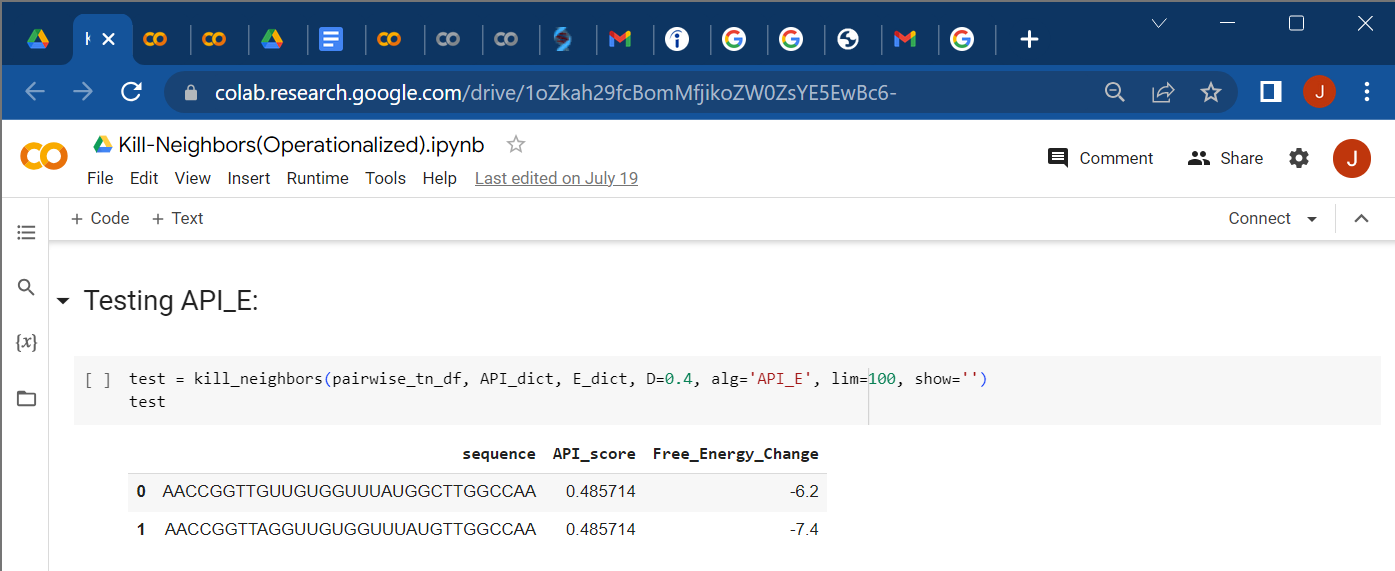

It's not exactly the same motif (ignore the end tags, of course), but... it's very close!

## Combinations Experiment:

In attempting to utilize all the data, all at once, I run into a wall, which is that as the number of sequences used doubles, the size of the matrix is quadrupled. I think that the solution here is the same "combinations" experiment I've been meaning to run.

### Test:

In [ ]:
nums = [10]

In [ ]:
results = {}
for n in nums:
  for m in range (1,(50-n)+2,n):
    #Errg, it's an indexing thing.
    x = m-1
    y = m+n-2
    All_Sequences, API_dict, E_dict, pairwise_tn_df = make_necessary_objects(file_list=file_lists['bPrP_25to35/15base_aptamers'][x:y])
    out = kill_neighbors(pairwise_tn_df, API_dict, E_dict, D=0.4, alg='API_E', lim=100, show='')
    print('Range is files:', x+1, 'to', y+1)
    results[str(x)+'-'+str(y)] = out
    print(out)

    name = 'bPrP_25to35_12b_kill_neighbors_output_['+str(x+1)+'-'+str(y+1)+']'
    out.to_csv(name, index=False)

Range is files: 1 to 10
                          sequence  API_score  Free_Energy_Change
0  UUGGCCAAAAACAGCUAUGGUUGUUGGCCAA   0.542857               -13.3
1  UUGGCCAAGACAGCUAUGGUUGUUUGGCCAA   0.542857               -15.6
2  UUGGCCAACUUGUGGUUUAAAAGUUGGCCAA   0.514286               -15.9
Range is files: 11 to 20
                          sequence  API_score  Free_Energy_Change
0  UUGGCCAACAUAUGUGGUUGAGUUUGGCCAA   0.514286               -10.2
1  UUGGCCAAAGCGGAUUUAUGUGGUUGGCCAA   0.571429               -12.5
Range is files: 21 to 30
                          sequence  API_score  Free_Energy_Change
0  UUGGCCAAAGAUUGGUUGGAGGUUUGGCCAA   0.542857               -12.1
1  UUGGCCAACAGAGGUUGGAUUGUUUGGCCAA   0.542857               -11.0
2  UUGGCCAAUAGGUUGGACAGCGUUUGGCCAA   0.514286               -11.9
Range is files: 31 to 40
                          sequence  API_score  Free_Energy_Change
0  UUGGCCAAAGCUGGCUAAUAUGGUUGGCCAA   0.514286               -10.2
1  UUGGCCAAUACAGCUGGCUAAUGUUGGCCAA   0.5142

Success!

**To be updated later, with structures for these candidates.... **